In [1]:
!pip install geopandas
!pip install pygeos pyproj
!apt install libspatialindex-dev
!pip install rtree
!pip install overpass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
gpd.options.use_pygeos = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import requests
import json
from shapely.ops import cascaded_union

import folium
from folium.plugins import HeatMap

from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from geopy.geocoders import Nominatim, Yandex

import overpass
from geopy import distance
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from functools import partial
import pyproj
from shapely.ops import transform

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [3]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [4]:
train['geometry'] = [Point(x,y) for x,y in zip (train.lon, train.lat)]
train_gdf = gpd.GeoDataFrame(train)


In [5]:
test['geometry'] = [Point(x,y) for x,y in zip (test.lon, test.lat)]
test_gdf = gpd.GeoDataFrame(test)

In [6]:
print(train.shape)
train.head(2)

(425, 5)


,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863)
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027)


In [7]:
print(test.shape)
test.head(2)

(107, 5)


,point_id,lon,lat,target,geometry
0,F4lXR1cG,37.681242,55.74804,0.0091,POINT (37.68124 55.74804)
1,4LJu4GTf,60.580910,56.79586,0.0091,POINT (60.58091 56.79586)


Для начала проверим датасет на выбросы, для этого пересечем его с АТД России

In [8]:
response = requests.get('https://nominatim.openstreetmap.org/search?country=Russia&polygon_geojson=1&format=json')
russia_bounds = json.loads(response.text)[0]['geojson']

In [9]:
polygons = []
for bound in russia_bounds['coordinates']:
  polygons.append(Polygon(bound[0]))
russia_polygon = cascaded_union(polygons)

In [10]:
russia_polygon

In [11]:
russia_gdf = gpd.GeoDataFrame({"geometry": russia_polygon})
train_gdf = gpd.sjoin(train_gdf, russia_gdf, op='intersects').drop('index_right', axis=1)
test_gdf = gpd.sjoin(test_gdf, russia_gdf, op='intersects').drop('index_right', axis=1)

In [12]:
russia_gdf.head(5)

,geometry
0,"POLYGON ((145.27636 43.83973, 145.28150 43.851..."
1,"POLYGON ((140.92206 46.25263, 140.92216 46.257..."
2,"POLYGON ((31.53313 52.48566, 31.53554 52.48607..."
3,"POLYGON ((167.07333 54.89120, 167.07601 54.910..."
4,"POLYGON ((19.40417 54.60390, 19.57757 54.73681..."


Как можно убедиться ниже, выбросов нет и все точки лежат в пределах АТД России

In [13]:
train_gdf

,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863)
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027)
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333)
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202)
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019)
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,POINT (37.62877 55.74066)
421,uNw6t6xk,37.586825,55.794233,-0.002397,POINT (37.58682 55.79423)
422,Ap42ei8k,37.678790,55.772910,-0.910019,POINT (37.67879 55.77291)
423,rn9A8r62,37.752130,55.619640,-0.326547,POINT (37.75213 55.61964)


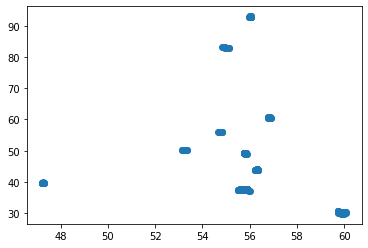

In [14]:
plt.scatter(train.lat, train.lon)

In [15]:
train.describe()

,lon,lat,target
count,425.000000,425.000000,425.000000
mean,45.466265,55.986388,0.009146
std,16.778159,2.734334,0.979238
min,29.765540,47.208802,-1.428660
25%,37.486227,55.609839,-0.650698
50%,37.707080,55.789394,-0.196887
75%,50.173675,56.350323,0.386584
max,93.023803,60.093366,7.215360


Теперь определим город, в котором лежат точки, т.к. overpass API не позволяет добраться до границ городов, а позволяет только выделить границы областей (см. https://wiki.openstreetmap.org/wiki/RU:Tag:boundary%3Dadministrative), то воспользуемся предложенным геокодером

In [16]:
geolocator = Nominatim(user_agent="megafon-hw-geocoder", timeout=300)

def get_city(point_data):
  location = geolocator.reverse("{}, {}".format(point_data.lat, point_data.lon))
  return location.raw['address'].get('city', '')


In [17]:
train_gdf['city'] = train_gdf.apply(get_city, axis=1)


In [18]:
train_gdf['city'].unique()

array(['Москва', 'Ростов-на-Дону', 'Красноярск', 'Санкт-Петербург', 'Уфа',
       'городской округ Казань', 'Екатеринбург', 'Нижний Новгород',
       'Колпино', 'Новосибирск', 'городской округ Новосибирск',
       'городской округ Самара', '', 'Самара', 'Казань', 'Зеленоград',
       'Балашиха', 'Пушкин'], dtype=object)

In [19]:
test_gdf['city'] = test_gdf.apply(get_city, axis=1)

In [20]:
test_gdf['city'].unique()

array(['Москва', 'Екатеринбург', 'городской округ Казань', 'Казань',
       'Санкт-Петербург', 'городской округ Самара', 'Новосибирск',
       'Нижний Новгород', 'городской округ Новосибирск', 'Ростов-на-Дону',
       'Уфа', 'Красноярск', 'Зеленоград', ''], dtype=object)

In [21]:
m = folium.Map(location=[60.093366, 93.023803], 
               zoom_start=3, 
               tiles='cartodbpositron')

heat_data = [[row['lat'],row['lon']] for index, row in train.iterrows()]


HeatMap(heat_data,
        radius=10).add_to(m)

m

In [22]:
train_gdf.head(5)

,point_id,lon,lat,target,geometry,city
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),Ростов-на-Дону
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва


In [23]:
train_gdf = pd.get_dummies(train_gdf, columns=["city"])


In [24]:
test_gdf = pd.get_dummies(test_gdf, columns=["city"])

In [25]:
train_gdf.head(5)


,point_id,lon,lat,target,geometry,city_,city_Балашиха,city_Екатеринбург,city_Зеленоград,city_Казань,city_Колпино,city_Красноярск,city_Москва,city_Нижний Новгород,city_Новосибирск,city_Пушкин,city_Ростов-на-Дону,city_Самара,city_Санкт-Петербург,city_Уфа,city_городской округ Казань,city_городской округ Новосибирск,city_городской округ Самара
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
test_gdf.head(5)

,point_id,lon,lat,target,geometry,city_,city_Екатеринбург,city_Зеленоград,city_Казань,city_Красноярск,city_Москва,city_Нижний Новгород,city_Новосибирск,city_Ростов-на-Дону,city_Санкт-Петербург,city_Уфа,city_городской округ Казань,city_городской округ Новосибирск,city_городской округ Самара
0,F4lXR1cG,37.681242,55.748040,0.0091,POINT (37.68124 55.74804),0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,4LJu4GTf,60.580910,56.795860,0.0091,POINT (60.58091 56.79586),0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,kLuAAN3s,37.598614,55.781357,0.0091,POINT (37.59861 55.78136),0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,OxQHvaNu,37.794051,55.717468,0.0091,POINT (37.79405 55.71747),0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,paQsTa1K,49.213026,55.748290,0.0091,POINT (49.21303 55.74829),0,0,0,0,0,0,0,0,0,0,0,1,0,0


Найдем расстояние до метро и количество станций метро в определенном радиусе для каждого салона.

In [27]:
def get_data_from_osm(request):
  overpass_query = request
  response = api.get(overpass_query, responseformat='json', verbosity='body')
  data_osm = pd.DataFrame(response['elements']).drop(['tags', 'type'], axis=1)
  data_osm['geometry'] = [Point(x,y) for x,y in zip(data_osm.lon, data_osm.lat)]
  return gpd.GeoDataFrame(data_osm)


In [28]:
api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=500)

In [31]:
request_metro = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["railway"="station"]["subway"="yes"];
);
'''
metro_station_osm = get_data_from_osm(request_metro)
metro_station_osm

,id,lat,lon,geometry
0,60660466,55.887177,37.661550,POINT (37.66155 55.88718)
1,60660469,55.869625,37.664184,POINT (37.66418 55.86963)
2,88802787,59.965080,30.312690,POINT (30.31269 59.96508)
3,88803981,59.955156,30.319457,POINT (30.31946 59.95516)
4,88833360,59.950195,30.289149,POINT (30.28915 59.95019)
...,...,...,...,...
195,7335523472,55.726948,37.753202,POINT (37.75320 55.72695)
196,7339988431,55.705025,37.819000,POINT (37.81900 55.70503)
197,7340764979,55.764922,37.706704,POINT (37.70670 55.76492)
198,7340764980,55.753643,37.719203,POINT (37.71920 55.75364)


Расстояние до ближайшей станции

In [32]:
tree = KDTree(metro_station_osm[['lat', 'lon']], metric='euclidean')

def find_nearest_node(tree, gdf, point):
    
    closest_idx = tree.query([(point.y, point.x)], k=1, return_distance=False)[0]
    nearest_node = gdf.iloc[closest_idx].index.values[0]
    
    return nearest_node

In [33]:
train_gdf = train_gdf.set_crs(epsg=4326)
test_gdf = test_gdf.set_crs(epsg=4326)

def get_nearest_dist(row, points_df):
  closest_node_to_es = find_nearest_node(tree, points_df, row['geometry'])
  points_coor = points_df.iloc[closest_node_to_es]['geometry'].y, points_df.iloc[closest_node_to_es]['geometry'].x
  salon_coor = row['geometry'].y, row['geometry'].x
  return distance.geodesic(points_coor, salon_coor).km

train_gdf['nearest_metro_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, metro_station_osm), axis=1)
test_gdf['nearest_metro_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, metro_station_osm), axis=1)

In [34]:
proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lon, lat, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf)

In [35]:
def near_count(shop, points_df, RADIUS_KM = 1):
  x, y = shop['geometry'].x, shop['geometry'].y
  buffer = geodesic_point_buffer(x, y, RADIUS_KM)
  return sum([buffer.contains(point) for point in points_df['geometry']])

Добавив данный признак и запустив модель получили, что MSE равно 0.598725505313247. Оставляем данный признак.

Количество станций метро в радиусе 1км.

In [36]:
train_gdf['metro_cnt_within_1km'] = train_gdf.apply(lambda row: near_count(row, metro_station_osm), axis=1)

In [37]:
test_gdf['metro_cnt_within_1km'] = test_gdf.apply(lambda row: near_count(row, metro_station_osm), axis=1)

In [38]:
train_gdf = train_gdf.drop('metro_cnt_within_1km', axis=1)
test_gdf = test_gdf.drop('metro_cnt_within_1km', axis=1)


Данный признак ухудшил MSE, поэтому убираем его из модели.

# Признаки, которые вошли в модель

Как уже было сказано ранее, в модель включаем признак расстояния до ближайшей станции метро.

Найдем расстояние до ближайшего торгового центра для каждого салона.

In [39]:
request_malls = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["shop"="mall"];
);
'''
malls_osm = get_data_from_osm(request_malls)

Расстояние

In [40]:
tree = KDTree(malls_osm[['lat', 'lon']], metric='euclidean')

train_gdf['malls_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, malls_osm), axis=1)
test_gdf['malls_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, malls_osm), axis=1)

Найдем количество ж/д вокзалов в радиусе трех метров для каждого салона.

In [41]:
request_trains = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["railway"="station"]["train"="yes"];
);
'''

trains_station_osm = get_data_from_osm(request_trains)

In [42]:
train_gdf['trains_cnt_within_3km'] = train_gdf.apply(lambda row: near_count(row, trains_station_osm, RADIUS_KM=3), axis=1)
test_gdf['trains_cnt_within_3km'] = test_gdf.apply(lambda row: near_count(row, trains_station_osm, RADIUS_KM=3), axis=1)

In [43]:
train_gdf['trains_cnt_within_3km'].value_counts()

0    257
1     77
3     39
2     31
4     15
5      5
6      1
Name: trains_cnt_within_3km, dtype: int64

Найдем расстояние до центра для каждого салона.

In [44]:
request_center = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["place"="city"];
);
'''
centers_osm = get_data_from_osm(request_center)

Расстояние

In [45]:
tree = KDTree(centers_osm[['lat', 'lon']], metric='euclidean')

train_gdf['centers_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, centers_osm), axis=1)
test_gdf['centers_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, centers_osm), axis=1)

Расстояние до ближайшей автобусной остановки

In [49]:
request_bus_station = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["amenity"="bus_station"];
);
'''
bus_station_osm = get_data_from_osm(request_bus_station)

In [50]:
tree = KDTree(bus_station_osm[['lat', 'lon']], metric='euclidean')

train_gdf['bus_station_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, bus_station_osm), axis=1)
test_gdf['bus_station_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, bus_station_osm), axis=1)

# Признаки, которые не вошли в модель.

Количество торговых центров в радиусе 300 метров для каждого салона(здесь и далее пробовала и другие радиусы, но скор все равно падал)

In [51]:
train_gdf['malls_cnt_within_0.3km'] = train_gdf.apply(lambda row: near_count(row, malls_osm, RADIUS_KM=0.3), axis=1)
test_gdf['malls_cnt_within_0.3km'] = test_gdf.apply(lambda row: near_count(row, malls_osm, RADIUS_KM=0.3), axis=1)

In [52]:
train_gdf['malls_cnt_within_0.3km'].value_counts()

0    400
1     21
2      3
3      1
Name: malls_cnt_within_0.3km, dtype: int64

In [53]:
train_gdf = train_gdf.drop('malls_cnt_within_0.3km', axis=1)
test_gdf = test_gdf.drop('malls_cnt_within_0.3km', axis=1)

Расстояние до ближайшего вокзала

In [54]:
tree = KDTree(trains_station_osm[['lat', 'lon']], metric='euclidean')

train_gdf['trains_station_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, trains_station_osm), axis=1)
test_gdf['trains_station_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, trains_station_osm), axis=1)

In [55]:
train_gdf = train_gdf.drop('trains_station_dist', axis=1)
test_gdf = test_gdf.drop('trains_station_dist', axis=1)

Рынки

In [56]:
request_marketplace = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["amenity"="marketplace"];
);
'''

marketplace_osm = get_data_from_osm(request_marketplace)

Расстояние до ближайшего рынка

In [57]:
tree = KDTree(marketplace_osm[['lat', 'lon']], metric='euclidean')

train_gdf['marketplace_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, marketplace_osm), axis=1)
test_gdf['marketplace_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, marketplace_osm), axis=1)

In [58]:
train_gdf = train_gdf.drop('marketplace_dist', axis=1)
test_gdf = test_gdf.drop('marketplace_dist', axis=1)

Количество рынков в радиусе

In [59]:
train_gdf['marketplace_cnt_within_0.5km'] = train_gdf.apply(lambda row: near_count(row, marketplace_osm, RADIUS_KM=0.2), axis=1)
test_gdf['marketplace_cnt_within_0.5km'] = test_gdf.apply(lambda row: near_count(row, marketplace_osm, RADIUS_KM=0.2), axis=1)

In [60]:
train_gdf['marketplace_cnt_within_0.5km'].value_counts()

0    407
1     17
2      1
Name: marketplace_cnt_within_0.5km, dtype: int64

In [61]:
train_gdf = train_gdf.drop('marketplace_cnt_within_0.5km', axis=1)
test_gdf = test_gdf.drop('marketplace_cnt_within_0.5km', axis=1)

Хостелы

In [62]:
request_hostels = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["tourism"="hostel"];
);
'''

hostels_osm = get_data_from_osm(request_hostels)

Расстояние до ближайшего

In [63]:
tree = KDTree(hostels_osm[['lat', 'lon']], metric='euclidean')

train_gdf['hostel_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, hostels_osm), axis=1)
test_gdf['hostel_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, hostels_osm), axis=1)

In [64]:
train_gdf = train_gdf.drop('hostel_dist', axis=1)
test_gdf = test_gdf.drop('hostel_dist', axis=1)

Количесво хостелов в радиусе

In [65]:
train_gdf['hostels_cnt_within_0.5km'] = train_gdf.apply(lambda row: near_count(row, hostels_osm, RADIUS_KM=0.2), axis=1)
test_gdf['hostels_cnt_within_0.5km'] = test_gdf.apply(lambda row: near_count(row, hostels_osm, RADIUS_KM=0.2), axis=1)

In [66]:
train_gdf['hostels_cnt_within_0.5km'].value_counts()

0    398
1     15
3      4
2      4
4      3
5      1
Name: hostels_cnt_within_0.5km, dtype: int64

In [67]:
train_gdf = train_gdf.drop('hostels_cnt_within_0.5km', axis=1)
test_gdf = test_gdf.drop('hostels_cnt_within_0.5km', axis=1)


Аэропорт

In [68]:
request_airports = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["aeroway"="gate"];
);
'''
airports_osm = get_data_from_osm(request_airports)

Расстояние

In [69]:
tree = KDTree(airports_osm[['lat', 'lon']], metric='euclidean')

train_gdf['airport_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, airports_osm), axis=1)
test_gdf['airport_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, airports_osm), axis=1)

In [70]:
train_gdf = train_gdf.drop('airport_dist', axis=1)
test_gdf = test_gdf.drop('airport_dist', axis=1)

количество

In [71]:
train_gdf['airports_cnt_within_1km'] = train_gdf.apply(lambda row: near_count(row, airports_osm, RADIUS_KM=0.5), axis=1)
test_gdf['airports_cnt_within_1km'] = test_gdf.apply(lambda row: near_count(row, airports_osm, RADIUS_KM=0.5), axis=1)

In [72]:
train_gdf = train_gdf.drop('airports_cnt_within_1km', axis=1)
test_gdf = test_gdf.drop('airports_cnt_within_1km', axis=1)

Количество автобусных остановок в радиусе

In [73]:
train_gdf['bus_station_cnt_within_0.3km'] = train_gdf.apply(lambda row: near_count(row, bus_station_osm, RADIUS_KM=0.3), axis=1)
test_gdf['bus_station_cnt_within_0.3km'] = test_gdf.apply(lambda row: near_count(row, bus_station_osm, RADIUS_KM=0.3), axis=1)

In [74]:
train_gdf['bus_station_cnt_within_0.3km'].value_counts()

0    410
1     13
3      2
Name: bus_station_cnt_within_0.3km, dtype: int64

In [75]:
train_gdf = train_gdf.drop('bus_station_cnt_within_0.3km', axis=1)
test_gdf = test_gdf.drop('bus_station_cnt_within_0.3km', axis=1)

Офисы

In [80]:
request_office = '''area["ISO3166-1"="RU"]->.searchArea;
(
  node(area.searchArea)["information"="office"];
);
'''
offices_osm = get_data_from_osm(request_office)

Расстояние

In [81]:
tree = KDTree(offices_osm[['lat', 'lon']], metric='euclidean')

train_gdf['offices_dist'] = train_gdf.apply(lambda row: get_nearest_dist(row, offices_osm), axis=1)
test_gdf['offices_dist'] = test_gdf.apply(lambda row: get_nearest_dist(row, offices_osm), axis=1)

In [82]:
train_gdf = train_gdf.drop('offices_dist', axis=1)
test_gdf = test_gdf.drop('offices_dist', axis=1)

Количество

In [83]:
train_gdf['offices_cnt_within_0.3km'] = train_gdf.apply(lambda row: near_count(row, offices_osm, RADIUS_KM=0.1), axis=1)
test_gdf['offices_cnt_within_0.3km'] = test_gdf.apply(lambda row: near_count(row, offices_osm, RADIUS_KM=0.1), axis=1)

In [84]:
train_gdf['offices_cnt_within_0.3km'].value_counts()

0    425
Name: offices_cnt_within_0.3km, dtype: int64

In [85]:
train_gdf = train_gdf.drop('offices_cnt_within_0.3km', axis=1)
test_gdf = test_gdf.drop('offices_cnt_within_0.3km', axis=1)

# Fit model

Разбиваем выборку на train и valid

In [113]:
X_train, X_valid, y_train, y_valid = train_test_split(train_gdf.drop('target', axis=1), train_gdf[['target']], test_size=0.33, random_state=42)


Попробуем обучить модель с помощью XGBRegressor

In [87]:
model = XGBRegressor(n_estimators=1000).fit(X_train.drop(['point_id', 'geometry'], axis=1), y_train)

[17:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [88]:
mean_absolute_error(y_valid, model.predict(X_valid.drop(['point_id', 'geometry'], axis=1)))

0.6714345676819411

In [89]:
scaler = StandardScaler()

X_train['nearest_metro_dist'] = scaler.fit_transform(X_train['nearest_metro_dist'].to_numpy().reshape(-1, 1))
X_valid['nearest_metro_dist'] = scaler.transform(X_valid['nearest_metro_dist'].to_numpy().reshape(-1, 1))
test_gdf['nearest_metro_dist'] = scaler.transform(test_gdf['nearest_metro_dist'].to_numpy().reshape(-1, 1))

In [90]:
X_train['malls_dist'] = scaler.fit_transform(X_train['malls_dist'].to_numpy().reshape(-1, 1))
X_valid['malls_dist'] = scaler.transform(X_valid['malls_dist'].to_numpy().reshape(-1, 1))
test_gdf['malls_dist'] = scaler.transform(test_gdf['malls_dist'].to_numpy().reshape(-1, 1))

In [91]:
X_train['centers_dist'] = scaler.fit_transform(X_train['centers_dist'].to_numpy().reshape(-1, 1))
X_valid['centers_dist'] = scaler.transform(X_valid['centers_dist'].to_numpy().reshape(-1, 1))
test_gdf['centers_dist'] = scaler.transform(test_gdf['centers_dist'].to_numpy().reshape(-1, 1))

In [92]:
X_train['bus_station_dist'] = scaler.fit_transform(X_train['bus_station_dist'].to_numpy().reshape(-1, 1))
X_valid['bus_station_dist'] = scaler.transform(X_valid['bus_station_dist'].to_numpy().reshape(-1, 1))
test_gdf['bus_station_dist'] = scaler.transform(test_gdf['bus_station_dist'].to_numpy().reshape(-1, 1))

Попробовала обучить нейронную сеть, но линейная регрессия показывает результат лучше

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

feature_cnt = len(X_train.drop(['point_id', 'geometry'], axis=1).columns)

model = Sequential()
model.add(Dense(feature_cnt * 2, input_dim=feature_cnt, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(feature_cnt * 2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), metrics=['mean_squared_error'])


In [ ]:
model.fit(X_train.drop(['point_id', 'geometry'], axis=1), y_train, epochs=450, batch_size=100)

In [95]:
model.evaluate(X_valid.drop(['point_id', 'geometry'], axis=1), y_valid)

5/5 [==============================] - 0s 2ms/step - loss: 0.6082 - mean_squared_error: 0.6082


[0.6081713438034058, 0.6081713438034058]

Обучаем линейную регрессию(из всех моделей она показала лучшие результаты)

In [96]:
model = LinearRegression().fit(X_train.drop(['point_id', 'geometry'], axis=1), y_train)

In [97]:
mean_absolute_error(y_valid, model.predict(X_valid.drop(['point_id', 'geometry'], axis=1)))

0.565216193148296

Тут результаты, полученные с помощью линейной регрессии с определенными признаками

nearest_metro_dist	malls_dist	trains_cnt_within_3km	centers_dist 0.5685232631963423

nearest_metro_dist	malls_dist	trains_cnt_within_3km	malls_cnt_within_0.3km 0.5788516920738966

**nearest_metro_dist	trains_cnt_within_3km	malls_dist 0.5735647507844563**

**nearest_metro_dist	trains_cnt_within_3km	bus_station_dist 0.5833800242037008 **

nearest_metro_dist	trains_cnt_within_1km	bus_station_cnt_within_0.3km 0.5844304185667459

nearest_metro_dist	trains_cnt_within_1km	bus_station_dist 0.5848167243824645

nearest_metro_dist	trains_cnt_within_1km airport_cnt_within_3km 0.5874274815080904

nearest_metro_dist	trains_cnt_within_1km airport_dist 0.5968506852450582

nearest_metro_dist trains_cnt_within_1km hostels_cnt_within_0.5km 0.5890771660934752

nearest_metro_dist trains_cnt_within_1km hostel_dist 0.5840120836046853

nearest_metro_dist trains_cnt_within_1km marketplace_cnt_within_0.5km 0.584366118993178

**nearest_metro_dist trains_cnt_within_1km 0.5838614100135594**

metro_cnt_within_1km 0.607772077960176

metro_cnt_within_1km nearest_metro_dist 0.6110367548625383

nearest_metro_dist 0.598725505313247

In [101]:
model.coef_

array([[-1.77390728e-01, -3.17628149e-01, -6.03192518e-01,
         2.45547494e+00,  3.44945756e+00, -1.34875234e+00,
         1.45333321e+00, -8.01499202e-01, -2.02054673e+00,
        -2.84657859e-01,  7.00939527e-01, -3.30938468e-01,
        -8.60422844e-16, -8.40776493e+00,  4.10130514e+00,
        -8.22620032e-01,  4.90027491e-03,  1.47276433e+00,
        -5.09372176e-01,  1.49116928e+00,  2.83803726e+00,
        -1.16289684e-01,  8.61208142e-02,  4.60811395e-02,
        -3.37202356e-02]])

In [102]:
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0)
clf.fit(X_train.drop(['point_id', 'geometry'], axis=1), y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [105]:
clf.coef_

array([[ 0.01250567, -0.08321422, -0.12349612,  1.32287685, -0.807523  ,
        -0.54495438, -0.38353407,  0.01737064,  0.06635185, -0.00531766,
        -0.33070824,  0.23900097,  0.        , -0.54127491,  2.13251095,
        -0.08686958, -0.64318421, -0.40245211,  0.09425859, -0.00305557,
        -0.25760053, -0.1002681 ,  0.08961187,  0.0876078 , -0.06434482]])

In [106]:
mean_absolute_error(y_valid, clf.predict(X_valid.drop(['point_id', 'geometry'], axis=1)))

0.572921072329471

При загрузке на Keggle скор получился меньше, чем в ноутбуке. Т.е. можно сделать вывод, что модель переобучилась. Поэтому было принято решение оставить только nearest_metro_dist, trains_cnt_within_1km. (на keggle модель с этими признаками дала скор 0.61572).

In [164]:
X_train, X_valid, y_train, y_valid = train_test_split(train_gdf.drop(['target', 'malls_dist',	'centers_dist',	'bus_station_dist', 'point_id', 'geometry'], axis=1), train_gdf[['target']], test_size=0.33, random_state=42)


In [165]:
scaler = StandardScaler()

X_train['nearest_metro_dist'] = scaler.fit_transform(X_train['nearest_metro_dist'].to_numpy().reshape(-1, 1))
X_valid['nearest_metro_dist'] = scaler.transform(X_valid['nearest_metro_dist'].to_numpy().reshape(-1, 1))
test_gdf['nearest_metro_dist'] = scaler.transform(test_gdf['nearest_metro_dist'].to_numpy().reshape(-1, 1))

In [166]:
model = LinearRegression()
model.fit(X_train, y_train)
print(mean_absolute_error(y_valid, model.predict(X_valid)))
model.coef_

0.5838614100135594


array([[-1.90993527e-01, -3.96550543e-01, -6.16913961e-01,
         2.75684054e+00,  4.03052604e+00, -1.24934725e+00,
         1.80801661e+00, -1.02871966e+00, -2.56425733e+00,
        -1.17583088e-01,  9.54239263e-01, -7.23436590e-01,
         9.03721542e-14, -9.69509129e+00,  4.23193302e+00,
        -4.48310483e-01,  8.81083744e-02,  1.80165454e+00,
        -8.75556729e-01,  1.64789799e+00,  3.20444010e+00,
         8.70598368e-02]])

In [171]:
from sklearn.linear_model import Ridge

clf = Ridge(alpha=0.0001)
clf.fit(X_train, y_train)
print(mean_absolute_error(y_valid, clf.predict(X_valid)))
model.coef_

0.5855029389781026


array([[-1.90993527e-01, -3.96550543e-01, -6.16913961e-01,
         2.75684054e+00,  4.03052604e+00, -1.24934725e+00,
         1.80801661e+00, -1.02871966e+00, -2.56425733e+00,
        -1.17583088e-01,  9.54239263e-01, -7.23436590e-01,
         9.03721542e-14, -9.69509129e+00,  4.23193302e+00,
        -4.48310483e-01,  8.81083744e-02,  1.80165454e+00,
        -8.75556729e-01,  1.64789799e+00,  3.20444010e+00,
         8.70598368e-02]])

Регуляризция не дала результата

Визуализация (карта приближена к Москве, но можно перетянуть на другие города)

In [156]:
def visual(priznak):
  m = folium.Map(location=[55.7522200, 37.6155600], 
               zoom_start=10, 
               tiles='cartodbpositron')

  heat_data = [[row['lat'],row['lon']] for index, row in priznak.iterrows()]


  HeatMap(heat_data,
        radius=10).add_to(m)
  return(m)



In [192]:
print('Распределение салонов')
visual(train_gdf)

Распределение салонов


In [193]:
print('Станции метро')
visual(metro_station_osm)

Станции метро


In [194]:
print('Торговые центры')
visual(malls_osm)

Торговые центры


In [195]:
print('Ж/Д станции')
visual(trains_station_osm)

Ж/Д станции


In [196]:
print('Автобусные остановки')
visual(bus_station_osm)

Автобусные остановки


### Make submission

In [108]:
test_gdf[['city_Балашиха', 'city_Самара', 'city_Пушкин', 'city_Колпино']] = 0
target = clf.predict(test_gdf[X_valid.columns].drop(['point_id', 'geometry'], axis=1))

In [109]:
test_gdf['target'] = target

In [110]:
test_gdf[['point_id', 'target']].to_csv('submission.csv', index=False)